In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import shutil

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

# Sistem Rekomendasi Kopi
Sistem rekomendasi yang dibuat bertujuan untuk merekomendasikan produk kopi kepada pengguna berdasarkan preferensi mereka terhadap tingkat asam dan tingkat aroma.



In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Load the data
tf.keras.backend.clear_session()
produk_kopi = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR0m9FjHszfjZh1ei--UGZnUivJQSoU2-pRdGrWNHaXtqBWneZNbEdoZg_cOZ87gJTDjJMtGcGphED_/pub?gid=165615979&single=true&output=csv')
konsumen_kopi = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR0m9FjHszfjZh1ei--UGZnUivJQSoU2-pRdGrWNHaXtqBWneZNbEdoZg_cOZ87gJTDjJMtGcGphED_/pub?gid=2012083633&single=true&output=csv')
data_kopi = produk_kopi
data = konsumen_kopi

# Select the relevant columns
input_features = ['jenisKelamin', 'kategoriProduk', 'skorAroma', 'skorAsam']
target_feature = 'idProduk'
data = data[input_features + [target_feature]].copy()

# Preprocess the data
label_encoder = LabelEncoder()
data['jenisKelamin'] = label_encoder.fit_transform(data['jenisKelamin'])
print("Label Encoder Mapping for jenisKelamin:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Number of unique labels for jenisKelamin:", data['jenisKelamin'].nunique())
print()

# data['asalUser'] = label_encoder.fit_transform(data['asalUser'])
data['kategoriProduk'] = label_encoder.fit_transform(data['kategoriProduk'])
print("Label Encoder Mapping for kategoriProduk:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Number of unique labels for kategoriProduk:", data['kategoriProduk'].nunique())
print()

data['idProduk'] = label_encoder.fit_transform(data['idProduk'])
print("Label Encoder Mapping for idProduk:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Number of unique labels for idProduk:", data['idProduk'].nunique())
print()
target = data[target_feature]


Label Encoder Mapping for jenisKelamin:
{'Laki-laki': 0, 'Perempuan': 1}
Number of unique labels for jenisKelamin: 2

Label Encoder Mapping for kategoriProduk:
{'Arabika': 0, 'Campuran': 1, 'Catuai': 2, 'Excelsa': 3, 'Liberika': 4, 'Luwak': 5, 'Robusta': 6, 'Single Origin': 7}
Number of unique labels for kategoriProduk: 8

Label Encoder Mapping for idProduk:
{'P001': 0, 'P002': 1, 'P003': 2, 'P004': 3, 'P005': 4, 'P006': 5, 'P007': 6, 'P008': 7, 'P009': 8, 'P010': 9, 'P011': 10, 'P012': 11, 'P013': 12, 'P014': 13, 'P015': 14, 'P016': 15, 'P017': 16, 'P018': 17, 'P019': 18, 'P020': 19, 'P021': 20, 'P022': 21, 'P023': 22, 'P024': 23, 'P025': 24, 'P026': 25, 'P027': 26, 'P028': 27, 'P029': 28, 'P030': 29, 'P031': 30, 'P032': 31, 'P033': 32, 'P034': 33, 'P035': 34, 'P036': 35, 'P037': 36, 'P038': 37, 'P039': 38, 'P040': 39, 'P041': 40, 'P042': 41, 'P043': 42, 'P044': 43, 'P045': 44, 'P046': 45, 'P048': 46, 'P049': 47, 'P050': 48, 'P051': 49, 'P052': 50}
Number of unique labels for idProduk

In [ ]:
produk_kopi

,idProduk,namaProduk,kategoriProduk,skorAroma,aroma,skorAsam,asam,asalProduk,kadarKafein,deskripsiProduk,hargaDollar,hargaRp,url,15000
0,P001,Kopi Arabika Sumatera,Arabika,8,Sangat kuat,6,Sedang,Sumatera Utara,High,Biji kopi Arabika berkualitas tinggi dengan ar...,$15.99,"Rp239,850",https://1.bp.blogspot.com/-_cUelNzWAiA/YHxfTz8...,NaN
1,P002,Kopi Robusta Vietnam,Robusta,7,Kuat,7,Cukup kuat,Vietnam,High,Biji kopi Robusta yang tumbuh subur di daerah ...,$12.99,"Rp194,850",https://s2.bukalapak.com/img/7697560331/large/...,NaN
2,P003,Kopi Single Origin Ethiopia,Arabika,9,Sangat intens,8,Kuat,Ethiopia,Medium,Biji kopi Arabika murni dari Ethiopia yang ter...,$18.99,"Rp284,850",https://images.tokopedia.net/img/cache/700/Vqb...,NaN
3,P004,Kopi Luwak,Luwak,8,Sangat kuat,6,Sedang,Indonesia,Medium,Kopi Luwak terkenal karena proses uniknya. Bij...,$99.99,"Rp1,499,850",https://luden.id/wp-content/uploads/2022/06/Me...,NaN
4,P005,Kopi Mocha,Campuran,8,Sangat kuat,7,Cukup kuat,Yaman,High,Kopi Mocha merupakan campuran antara biji kopi...,$14.99,"Rp224,850",https://www.starbucksathome.com/id/sites/defau...,NaN
5,P006,Kopi Papua Wamena,Arabika,8,Sangat kuat,7,Cukup kuat,Papua,Medium,Biji kopi Arabika dari wilayah Wamena di Papua...,$16.99,"Rp254,850",https://images.tokopedia.net/img/cache/500-squ...,NaN
6,P007,Kopi Blue Mountain,Arabika,9,Sangat intens,8,Kuat,Jamaica,Medium,Biji kopi Arabika yang tumbuh di Pegunungan Bi...,$49.99,"Rp749,850",https://www.static-src.com/wcsstore/Indraprast...,NaN
7,P008,Kopi Excelsa,Excelsa,8,Sangat kuat,6,Sedang,Vietnam,Medium,"Biji kopi Excelsa, salah satu varietas kopi Ro...",$13.99,"Rp209,850",https://redaksi.inibaru.id/nuploads/59/excelsa...,NaN
8,P009,Kopi Java,Arabika,7,Kuat,6,Sedang,Jawa,High,"Biji kopi Arabika dari pulau Jawa, Indonesia. ...",$17.99,"Rp269,850",https://agrivisi.id/wp-content/uploads/2022/07...,NaN
9,P010,Kopi Catuai,Catuai,7,Kuat,7,Cukup kuat,Amerika Tengah,High,Biji kopi Arabika varietas Catuai yang tumbuh ...,$11.99,"Rp179,850",https://www.google.com/url?sa=i&url=https%3A%2...,NaN


In [ ]:
numerical_features = ['skorAroma', 'skorAsam']
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])
data

X = data[input_features]
y = target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlronp_callback = ReduceLROnPlateau(monitor="val_loss", patience=3, min_lr=1e-6, verbose=1)
callbacks = [rlronp_callback, early_stopping_callback]

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_split=0.1, verbose=1, callbacks=callbacks)
loss, accuracy = model.evaluate(X_test, y_test)
print("-----------")
print(f"Test set accuracy: {accuracy:.3f}")


Epoch 1/1000
9/9 [==============================] - 1s 37ms/step - loss: 3.8570 - accuracy: 0.0705 - val_loss: 3.7054 - val_accuracy: 0.1613 - lr: 0.0010
Epoch 2/1000
9/9 [==============================] - 0s 13ms/step - loss: 3.5770 - accuracy: 0.1175 - val_loss: 3.3561 - val_accuracy: 0.1452 - lr: 0.0010
Epoch 3/1000
9/9 [==============================] - 0s 13ms/step - loss: 3.1310 - accuracy: 0.1808 - val_loss: 2.8936 - val_accuracy: 0.2903 - lr: 0.0010
Epoch 4/1000
9/9 [==============================] - 0s 13ms/step - loss: 2.6541 - accuracy: 0.2857 - val_loss: 2.4285 - val_accuracy: 0.2419 - lr: 0.0010
Epoch 5/1000
9/9 [==============================] - 0s 12ms/step - loss: 2.2301 - accuracy: 0.3671 - val_loss: 2.0334 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 6/1000
9/9 [==============================] - 0s 13ms/step - loss: 1.9014 - accuracy: 0.4268 - val_loss: 1.6764 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 7/1000
9/9 [==============================] - 0s 10ms/step - loss: 1.6

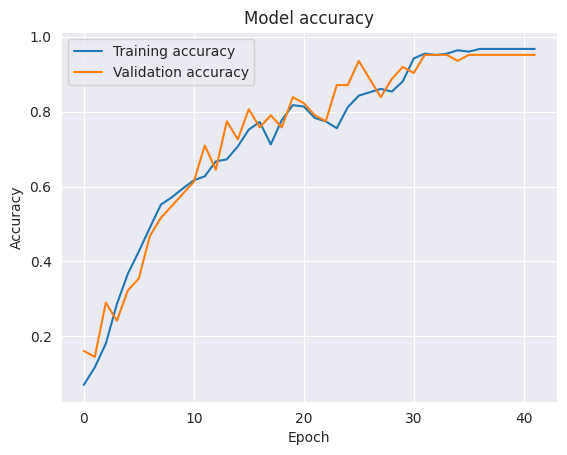

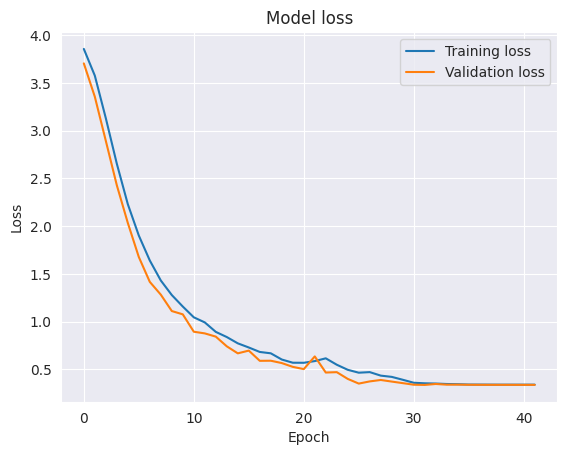

In [ ]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [ ]:
konsumen_kopi = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQtEP7pXFe4wDLGOkYqTeLH5ijXika9MjtVeNf6lfhd9CmOvIZzy5f3etn2NOV1fah-FwCqkOqjujwr/pub?gid=2012083633&single=true&output=csv')


label_encoder = LabelEncoder()
konsumen_kopi['jenisKelamin'] = label_encoder.fit_transform(konsumen_kopi['jenisKelamin'])
print("Label Encoder Mapping for jenisKelamin:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Number of unique labels for jenisKelamin:", konsumen_kopi['jenisKelamin'].nunique())
print()

# data['asalUser'] = label_encoder.fit_transform(data['asalUser'])
konsumen_kopi['kategoriProduk'] = label_encoder.fit_transform(konsumen_kopi['kategoriProduk'])
print("Label Encoder Mapping for kategoriProduk:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Number of unique labels for kategoriProduk:", konsumen_kopi['kategoriProduk'].nunique())
print()

konsumen_kopi['idProduk'] = label_encoder.fit_transform(konsumen_kopi['idProduk'])
print("Label Encoder Mapping for idProduk:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Number of unique labels for idProduk:", konsumen_kopi['idProduk'].nunique())
print()



Label Encoder Mapping for jenisKelamin:
{'Laki-laki': 0, 'Perempuan': 1}
Number of unique labels for jenisKelamin: 2

Label Encoder Mapping for kategoriProduk:
{'Arabika': 0, 'Campuran': 1, 'Catuai': 2, 'Excelsa': 3, 'Liberika': 4, 'Luwak': 5, 'Robusta': 6, 'Single Origin': 7}
Number of unique labels for kategoriProduk: 8

Label Encoder Mapping for idProduk:
{'P001': 0, 'P002': 1, 'P003': 2, 'P004': 3, 'P005': 4, 'P006': 5, 'P007': 6, 'P008': 7, 'P009': 8, 'P010': 9, 'P011': 10, 'P012': 11, 'P013': 12, 'P014': 13, 'P015': 14, 'P016': 15, 'P017': 16, 'P018': 17, 'P019': 18, 'P020': 19, 'P021': 20, 'P022': 21, 'P023': 22, 'P024': 23, 'P025': 24, 'P026': 25, 'P027': 26, 'P028': 27, 'P029': 28, 'P030': 29, 'P031': 30, 'P032': 31, 'P033': 32, 'P034': 33, 'P035': 34, 'P036': 35, 'P037': 36, 'P038': 37, 'P039': 38, 'P040': 39, 'P041': 40, 'P042': 41, 'P043': 42, 'P044': 43, 'P045': 44, 'P046': 45, 'P048': 46, 'P049': 47, 'P050': 48, 'P051': 49, 'P052': 50}
Number of unique labels for idProduk

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Example input data
# gender
# kategori
# skorAroma
# skorAsam

from sklearn.preprocessing import MinMaxScaler

# Example input data
input_data = np.array([[1, 5, 5, 5]])

# Create a new instance of MinMaxScaler and fit it on the training data
scaler = MinMaxScaler()
scaler.fit(X_train[:, 2:4])  # Scale only the 3rd and 4th indices

# Apply scaling to the desired columns in input_data
input_data[:, 2:4] = scaler.transform(input_data[:, 2:4])

# Predict the class probabilities
predicted_probs = model.predict(input_data)

# Get the top 3
top_predictions = np.argsort(-predicted_probs, axis=1)[:, :3]  # Change 5 to 10 for top 10 predictions

# Decode the predicted classes
predicted_classes = label_encoder.inverse_transform(top_predictions[0])

# Get the corresponding product names
idProduk_mapping = dict(data_kopi[['idProduk', 'namaProduk']].values)
predicted_product_names = [idProduk_mapping[predicted_id] for predicted_id in predicted_classes]

# Print the top 5 or 10 predictions along with the product names
print("Top Predictions:")
for i, (predicted_class, product_name) in enumerate(zip(predicted_classes, predicted_product_names)):
    confidence = predicted_probs[0, top_predictions[0][i]]
    print(f"{i+1}. Predicted idProduk: {predicted_class}, Nama Kopi : {product_name} (Confidence: {confidence:.10f})")

1/1 [==============================] - 0s 67ms/step
Top Predictions:
1. Predicted idProduk: P052, Nama Kopi : Kopi Robusta Sumatra (Confidence: 0.9888311028)
2. Predicted idProduk: P038, Nama Kopi : Kopi Espresso Blend (Confidence: 0.0110009406)
3. Predicted idProduk: P004, Nama Kopi : Kopi Luwak (Confidence: 0.0001222117)


In [ ]:
model.save('model.h5')